<style>
r { color: Red }
o { color: Orange }
g { color: Green }
</style>
This is my color style for this notebook:)
- <r>Red</r> 
- <o>Orange</o> 
- <g>Green</g> 

# **Practical 5**

Welcome to the last practical for Graph Representation Learning.

We will be implementing the 1-WL hash algorithm that is described in the lectures and testing it on several graphs and GNNs.

The main goal of the practical is creating a working implementation of the 1-WL hash algorithm and understanding its applicability and limitations.

The notebook is divided into sections, each of which comes with complete or partially completed code. Before each snippet of code there will be a description of what we are about to implement. The sections of code you need to complete are marked as Tasks.

Please ensure that you operate within the framework given in the notebook and bring any questions you may have to the practical demonstrators. We suggest that you DO NOT edit code that is a part of the framework, since this will make it more difficult for demonstrators to assist if your code is broken.

In [1]:
# Check PyTorch version installed on this system
!python -c "import torch; print(torch.__version__)"

2.2.2


In [2]:
%%capture
# Download the corresponding PyTorch Geometric module
"""
Assign to TORCH with what you get from the cell above. E.g., export TORCH=1.12.1+cu113
"""
%env TORCH=2.0.1+cu118
!pip install torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install torch-geometric

In [3]:
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch_geometric.utils import from_networkx
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import Sequential, GCNConv, global_mean_pool
import networkx as nx
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
rng = np.random.default_rng()

# **Part 1: Weisfeiler Lehman Graph Hash**

## **Task 1.1: Generate graph pairs using NetworkX**

For $n$ between 6 and 15, generate all pairs of graphs $(\mathcal{C_n}, \mathcal{D}_{n,i}))$, where $\mathcal{C}_n$ is a cycle on $n$ nodes and $\mathcal{D}_{n,i}$ is the disjoint union of two cycles, with $n - i$ and $i$ nodes in total (of course the minimum number of nodes in each single connected component you build should be $> 2$). You can use the functions provided by networkx. We suggest you build on top of `networkx.cycle_graph`.

In [4]:
# The range of different graph sizes
size_range = range(6, 16)

# The list of all graph pairs
graph_pairs = []

# Generate the graphs
for n in size_range:
	for i in range(3, n - 2):  # i ranges from 3 to n-3 to ensure both cycles have > 2 nodes
		# Cycle Cn (a simple cycle of n nodes)
		Cn = nx.cycle_graph(n)
		
		# Cycle Dn,i (disjoint union of two cycles)
		cycle1 = nx.cycle_graph(n - i)
		cycle2 = nx.cycle_graph(i)
		Dni = nx.disjoint_union(cycle1, cycle2)
		
		graph_pairs.append((Cn, Dni))


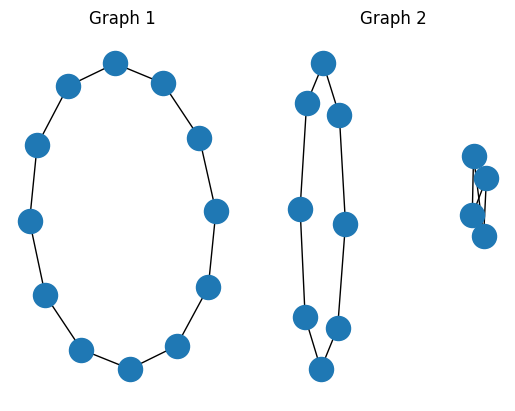

In [5]:
### DO NOT MODIFY

# Display a random pair
fig, axs = plt.subplots(1, 2)
pair = random.choice(graph_pairs)
for i in range(2):
	nx.draw(pair[i], ax=axs[i])
	axs[i].set_title(f"Graph {i+1}")
plt.show()

In [ ]:
# Test Block
C5 = nx.cycle_graph(5)
node_labels = {node: "1" for node in C5.nodes()}
node_labels

{0: '1', 1: '1', 2: '1', 3: '1', 4: '1'}

In [ ]:
# Test Block
sorted(C5.nodes())

[0, 1, 2, 3, 4]

In [ ]:
# Test Block
C5.degree()

DegreeView({0: 2, 1: 2, 2: 2, 3: 2, 4: 2})

In [ ]:
# Test Block
shortest_paths = dict(nx.all_pairs_shortest_path_length(C5))
print(shortest_paths)
# distance between node 2 and node 4 (2--3--4 so should return 2)
print(shortest_paths[2][4])

{0: {0: 0, 1: 1, 4: 1, 2: 2, 3: 2}, 1: {1: 0, 0: 1, 2: 1, 4: 2, 3: 2}, 2: {2: 0, 1: 1, 3: 1, 0: 2, 4: 2}, 3: {3: 0, 2: 1, 4: 1, 1: 2, 0: 2}, 4: {4: 0, 3: 1, 0: 1, 2: 2, 1: 2}}
2


In [ ]:
# Test Block
nodes_distance = []
for node1 in C5.nodes():
    for node2 in C5.nodes():
    	nodes_distance.append(shortest_paths[node1][node2])
nodes_distance

[0, 1, 2, 2, 1, 1, 0, 1, 2, 2, 2, 1, 0, 1, 2, 2, 2, 1, 0, 1, 1, 2, 2, 1, 0]

## **Task 1.2: Implement the Weisfeiler Lehman (WL) graph hash**

<style>
r { color: Red }
o { color: Orange }
g { color: Green }
</style>

<o>

Some notes on **hash**.

A hash is a fixed-length string of characters (usually a combination of letters and numbers) generated by a hash function. It serves as a unique representation (or "fingerprint") of some input data, such as a file, text, or graph structure.

Applications of Hashing:

1. Data Integrity:
	- Hashes can verify whether data has been tampered with. For example, downloading a file and comparing its hash with the expected hash ensures the file hasn't changed.
2. Password Storage:
	- Instead of storing plain-text passwords, systems store hashes of passwords. When a user logs in, their password is hashed and compared with the stored hash.
3. Cryptographic Security:
	- Hash functions like SHA-256 and MD5 are used in encryption and digital signatures for secure communications.
4. Hash Tables:
	 - In programming, hash functions are used to map data to unique indices in hash tables, enabling efficient data retrieval.
5. Graph Hashing:
	- For graph structures, hashes like the Weisfeiler-Lehman hash provide a way to compare graphs or use them in machine learning.

</o>

In [11]:
import hashlib

data = "Hello, World!"
hash_value = hashlib.md5(data.encode()).hexdigest() 
# hash_value = hashlib.sha256(data.encode()).hexdigest()

print("Original Data:", data)
print("MD5 Hash:", hash_value)

Original Data: Hello, World!
MD5 Hash: 65a8e27d8879283831b664bd8b7f0ad4


<style>
r { color: Red }
o { color: Orange }
g { color: Green }
</style>

<o>

**A breakdown of above codes**

`data.encode()`
- `data` is the input string to be hashed (e.g., `"Hello, World!"`).
- `.encode()` converts the string into a byte representation (UTF-8 encoding by default) because hash functions work on bytes, not strings.
- The `b` prefix indicates that this is a byte string, not a regular string.
	```python
	data = "Hello, World!"
	print(data.encode())
	# Output: b'Hello, World!'
	```

`hashlib.md5()`
- `hashlib.md5()` creates a new MD5 hash object. The MD5 algorithm processes the input bytes to generate a fixed-length, 128-bit (16-byte) hash value.
- At this point, the hash object is initialized, but the actual hash value is not yet in a usable form.

- `.hexdigest()`
- The `.hexdigest()` method is called on the MD5 hash object.
- It computes the final hash value and returns it as a hexadecimal string (a string consisting of numbers and lowercase letters `a-f`).
- For example:
	```python
	print(hashlib.md5(b"Hello, World!").hexdigest())
	# Output: fc3ff98e8c6a0d3087d515c0473f8677
	```
- Why Hexadecimal?
  
  The hash output is binary by nature. Representing it in hexadecimal makes it more compact and human-readable while maintaining all the information. For example:
  - `.digest()`: Returns the raw binary hash output (16 bytes).
	```python
	hash_object = hashlib.md5(b"Hello, World!")
	print(hash_object.digest())
	# Output: b'\xfc?\xf9\x8e\x8cj\r0\x87\xd5\x15\xc0G?\x86w'
	```

  - `.hexdigest()`: Converts the binary hash to a readable hexadecimal string (32 characters).
  
  	```python
	hash_object = hashlib.md5(b"Hello, World!")
	print(hash_object.hexdigest())
	# Output: fc3ff98e8c6a0d3087d515c0473f8677
	```
**Important Notes About MD5:**

- Not Secure for Cryptography:

	MD5 is fast but not collision-resistant, meaning two different inputs can sometimes produce the same hash. It is no longer recommended for security-critical applications.

- Use stronger algorithms like **SHA-256** for cryptographic purposes (what I'll use in later code cells).

</o>

Implement the function `weisfeiler_lehman_graph_hash` that takes in input a graph $\mathcal{G}$ and return the hash $WL(\mathcal{G})$. Use the constant $c = 1$ as the label for each node. For this task, you **cannot** use the utilities provided by the networkx library (except to convert from graphs to tensors if necessary).

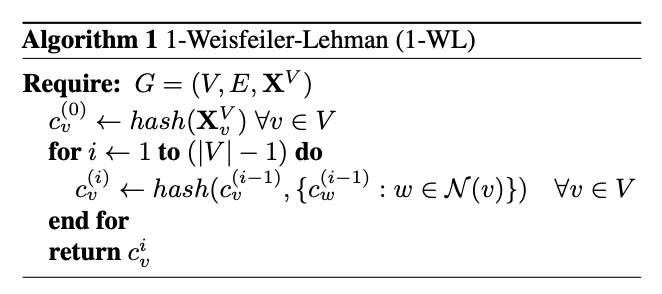

In [12]:
def weisfeiler_lehman_graph_hash(graph):
	"""
	Implements the 1-WL graph hashing algorithm.

	Parameters:
	graph (networkx.Graph): Input graph.

	Returns:
	str: Hash of the graph after WL iterations.
	"""

	# Step 1: Initialize node labels with constant c=1 and hash it
	node_labels = {node: hashlib.sha256("1".encode()).hexdigest() for node in graph.nodes()}

	# (n-1) of WL iterations to perform where n = #nodes
	# See Sandra Kiefer, Power and Limits of the Weisfeiler-Leman Algorithm, 2020. for more details
	for _ in range(len(node_labels) - 1):
		# Step 2: Aggregate neighbor labels and relabel nodes
		new_labels = {}
		for node in graph.nodes():
			# Collect the labels of the neighbors
			# Use sorting to ensure order invariance
			neighbor_labels = sorted([node_labels[neighbor] for neighbor in graph.neighbors(node)])
			# Combine the current label with the sorted neighbor labels
			combined_label = node_labels[node] + "|" + "|".join(neighbor_labels)
			# Hash the combined label to create a new label
			new_labels[node] = hashlib.sha256(combined_label.encode()).hexdigest()
		# Update the node labels
		node_labels = new_labels

	# Step 3: Generate a graph hash
	# Sort the labels and concatenate them to create the graph's final hash
	graph_hash = hashlib.sha256("".join(sorted(node_labels.values())).encode()).hexdigest()

	return graph_hash


Let's do a sanity check to make sure that the members of each pair previously generated are 1-WL indistinguishable:

In [13]:
### DO NOT MODIFY

wl_indistinguishable_pairs = 0
for pair in graph_pairs:
	hash0 = weisfeiler_lehman_graph_hash(pair[0])
	hash1 = weisfeiler_lehman_graph_hash(pair[1])
	wl_indistinguishable_pairs += (hash0 == hash1)

# Print the number of pairs produced
print(f"Number of graph pairs: {len(graph_pairs)}")
print(f"Number of 1-WL indistinguishable pairs: {wl_indistinguishable_pairs}")

Number of graph pairs: 55
Number of 1-WL indistinguishable pairs: 55


# Part 2: WL with extra node information

## **Task 2.1: Updating the hash function**

Modify the `weisfeiler_lehman_graph_hash` to accept an optional extra element corresponding to the features to assign to each node to be used to compute the final hash.

### Task 2.1.1
Use the node degree as initial label to compute the WL hash. What do you expect to change compared to before? Why?

In [14]:
def node_degrees(graph):
	"""Returns a list with the degree of each node in graph"""
	return [degree for _, degree in graph.degree()]


In [15]:
def weisfeiler_lehman_graph_hash(graph, node_features=None):
	"""
	Implements the 1-WL graph hashing algorithm with optional initial features.

	Parameters:
	graph (networkx.Graph): Input graph.
	node_features (dict, optional): Initial features for each node as a dictionary
									 where keys are nodes and values are features.

	Returns:
	str: Hash of the graph after WL iterations.
	"""

	# Step 1: Initialize node labels with hash
	if node_features:
		node_labels = {node: hashlib.sha256(str(node_features[node]).encode()).hexdigest() for node in graph.nodes()}
	else:
		# Default initialization with constant c=1
		node_labels = {node: hashlib.sha256("1".encode()).hexdigest() for node in graph.nodes()}

	# Perform WL iterations
	for _ in range(len(node_labels) - 1):
		# Step 2: Aggregate neighbor labels and relabel nodes
		new_labels = {}
		for node in graph.nodes():
			# Collect the labels of the neighbors
			neighbor_labels = sorted([node_labels[neighbor] for neighbor in graph.neighbors(node)])
			# Combine the current label with the sorted neighbor labels
			combined_label = node_labels[node] + "|" + "|".join(neighbor_labels)
			# Hash the combined label to create a new label
			new_labels[node] = hashlib.sha256(combined_label.encode()).hexdigest()
		# Update the node labels
		node_labels = new_labels

	# Step 3: Generate a graph hash
	# Note here we use sorting again to make sure that nodes indexing doesn't affect the final graph hash
	graph_hash = hashlib.sha256("".join(sorted(node_labels.values())).encode()).hexdigest()

	return graph_hash

In [16]:
### DO NOT MODIFY

wl_indistinguishable_pairs_with_degree = 0
for pair in graph_pairs:
	hash0 = weisfeiler_lehman_graph_hash(pair[0], node_degrees(pair[0]))
	hash1 = weisfeiler_lehman_graph_hash(pair[1], node_degrees(pair[1]))
	wl_indistinguishable_pairs_with_degree += (hash0 == hash1)

# Print the number of pairs produced
print(f"Number of graph pairs: {len(graph_pairs)}")
print(f"Number of 1-WL indistinguishable pairs when"
	  f"using the node degree as label: {wl_indistinguishable_pairs_with_degree}")

Number of graph pairs: 55
Number of 1-WL indistinguishable pairs whenusing the node degree as label: 55


### Task 2.1.2
Modify the initial label of each node $N_i$ such that it now contains the shortest path length from $N_i$ to $N_j$. Run `weisfeiler_lehman_graph_hash` using the new labels.

In [17]:
def node_shortest_paths(graph):
	"""Returns a list with the lenghts of the shortest paths between all the node pairs"""
	
	# Get a sorted list of nodes to ensure consistent indexing
	nodes = sorted(graph.nodes())
	n = len(nodes)
	# Initialize the 2D list
	shortest_paths = [[float('inf')] * n for _ in range(n)]
	# Compute all-pairs shortest paths
	lengths = dict(nx.all_pairs_shortest_path_length(graph))

	for i, source in enumerate(nodes):
		for j, target in enumerate(nodes):
			# If 2 nodes are not connected, then their distance is 'inf' (infinity)
			if target in lengths[source]:
				shortest_paths[i][j] = lengths[source][target]
			
	return shortest_paths



In [18]:
my_dict = {'a' : 'car', 'b' : 'boss', 'c' : 'apple'}
bool = 'b' in my_dict
bool

True

In [19]:
node_shortest_paths(C5)

[[0, 1, 2, 2, 1],
 [1, 0, 1, 2, 2],
 [2, 1, 0, 1, 2],
 [2, 2, 1, 0, 1],
 [1, 2, 2, 1, 0]]

In [20]:
str(node_shortest_paths(C5)[0])

'[0, 1, 2, 2, 1]'

In [21]:
### DO NOT MODIFY

wl_indistinguishable_pairs_with_shortest_path = 0
for pair in graph_pairs:
	hash0 = weisfeiler_lehman_graph_hash(pair[0], node_shortest_paths(pair[0]))
	hash1 = weisfeiler_lehman_graph_hash(pair[1], node_shortest_paths(pair[1]))
	wl_indistinguishable_pairs_with_shortest_path += (hash0 == hash1)

# Print the number of pairs produced
print(f"Number of graph pairs: {len(graph_pairs)}")
print(f"Number of 1-WL indistinguishable pairs when "
	  f"using the shortest path lenghts as label: {wl_indistinguishable_pairs_with_shortest_path}")

Number of graph pairs: 55
Number of 1-WL indistinguishable pairs when using the shortest path lenghts as label: 0


# **Part 3: Building a GNN**

## **Task 3.1: Converting the graphs from Task 1.1 to PyTorch Geometric objects**

Let's turn each graph into `torch_geometric.data.Data` objects, with some input features `x` and output features `y`.
Each previously generated pair should be converted to two Data objects, one for the cycle graph and one for the disjoint union one. The features `x` corresponds to the labels of each node; we will use the same label for each node (e.g., an array of 50 elements each set to 1). The output `y` should be 1 for cycle graphs and 0 for disjoint graphs.

(Look at the function `from_networkx`)

In [22]:
# The list of Data objects
dataset = []

# Loop over graph pairs
for Cn, Dni in graph_pairs:
    # Convert and process the cycle graph (Cn)
    Cn_geom = from_networkx(Cn)
    num_nodes_Cn = Cn.number_of_nodes()
    Cn_geom.x = torch.ones((num_nodes_Cn, 50), dtype=torch.float)  # Features
    Cn_geom.y = torch.tensor([1], dtype=torch.long)  # Label: 1 for cycle graphs
    dataset.append(Cn_geom)

    # Convert and process the disjoint union graph (Dni)
    Dni_geom = from_networkx(Dni)
    num_nodes_Dni = Dni.number_of_nodes()
    Dni_geom.x = torch.ones((num_nodes_Dni, 50), dtype=torch.float)  # Features
    Dni_geom.y = torch.tensor([0], dtype=torch.long)  # Label: 0 for disjoint graphs
    dataset.append(Dni_geom)


print(dataset[0], dataset[0].y)
print(dataset[1], dataset[1].y)
print(dataset[2], dataset[2].y)
print(dataset[3], dataset[3].y)
print(len(dataset))

Data(edge_index=[2, 12], num_nodes=6, x=[6, 50], y=[1]) tensor([1])
Data(edge_index=[2, 12], num_nodes=6, x=[6, 50], y=[1]) tensor([0])
Data(edge_index=[2, 14], num_nodes=7, x=[7, 50], y=[1]) tensor([1])
Data(edge_index=[2, 14], num_nodes=7, x=[7, 50], y=[1]) tensor([0])
110


## **Part 3.2: Defining the model**
Let's define our graph neural network. First, we define a module for doing mean pooling.

In [23]:
class GlobalMeanPool(nn.Module):
	"""Global mean pool layer."""

	def forward(self, x, batch=None, size=None):

		# If we don't get the batch vector, set it to zeros.
		if batch is None:
			batch = x.new_zeros(x.size(0), dtype=torch.int64)

		return global_mean_pool(x, batch, size)

This is the base GNN model. The function _layer_sequence specifies the list of modules which define the model.

In [24]:
class GraphSequenceModel(nn.Module):
	"""A GNN consisting of a stack of layers."""

	def __init__(self, *args, **kwargs):
		super().__init__()
		sequence = self._layer_sequence(*args, **kwargs)
		self.stack = Sequential("x, edge_index, batch", sequence)

	def forward(self, batch):
		return self.stack.forward(batch.x, batch.edge_index, batch.batch)

	@staticmethod
	def _weight_reset(module):
		if isinstance(module, GCNConv) or isinstance(module, nn.Linear):
			module.reset_parameters()

	def reset_parameters(self):
		return self.stack.apply(type(self)._weight_reset)

Finally, here is the model specification itself:

In [25]:
class MPNN(GraphSequenceModel):
	"""An MPNN with a `num_layers` message passing layers, then an MLP."""

	def _layer_sequence(self, num_layers=16):

		# The sequence of layers
		sequence = []

		# Add `num_layers` message passing layers
		for i in range(num_layers):
			sequence.append((GCNConv(50, 50), f"x, edge_index -> x"))
			sequence.append(nn.ReLU())

		# A global mean pool layer
		sequence.append((GlobalMeanPool(), f"x, batch -> x"))

		# Add an MLP at the end
		sequence.extend([
			(nn.Linear(50, 70), "x -> x"),
			nn.ReLU(),
			(nn.Linear(70, 25), "x -> x"),
			nn.ReLU(),
			(nn.Linear(25,2), "x -> x")
		])

		return sequence

Let's now instantiate the model:

In [26]:
model1 = MPNN(num_layers=16).to(device)

## **Part 3.3: Training, testing and cross-validation functions**
This is the generic training loop, which does one epoch-worth of training:


In [27]:
def train_epoch(dataloader, model, loss_fn, optimiser):
	"""Do one epoch-worth of training."""

	# Put the model in training mode
	model.train()

	# The number of datapoints
	size = len(dataloader.dataset)

	# Loop over each batch of datapoints
	for data in dataloader:

		# Set all the gradients to zero
		optimiser.zero_grad()

		# Make a prediction using the current parameters
		pred = model(data)

		# Compute the loss for this prediction
		loss = loss_fn(pred, data.y)

		# Propagate the loss backwards to compute the gradients
		loss.backward()

		# Do one step of optimisation
		optimiser.step()

This function does a full train on the data:

In [28]:
def train(train_dataloader, test_dataloader, model, loss_fn, optimiser,
		  epochs=200, output_every=20):
	"""Train a model for a certain number of epochs."""

	# Loop through the epochs
	for t in range(1, epochs+1):

		# Do the training for this epoch
		train_epoch(train_dataloader, model, loss_fn, optimiser)

		# Output the accuracy of the model every so often
		if output_every is not None and t % output_every == 0:
			print(f"Epoch {t}")
			print("----------------------------")
			print(f"Train accuracy: {test(train_dataloader, model):%}")
			print(f"Test accuracy: {test(test_dataloader, model):%}")
			print()

This function tests the model on the data, and returns the accuracy:

In [29]:
def test(dataloader, model):
	"""Test a model on some data."""

	# Put the model in evaluation mode
	model.eval()

	# Get the number of datapoints
	size = len(dataloader.dataset)

	# The number of correct predictions
	correct = 0

	# We don't want to be computing the gradients
	with torch.no_grad():

		# Loop through the minibatches
		for data in dataloader:

			# Compute the model predictions
			pred = model(data)

			# Update with the number of correct predictions
			correct += (pred.argmax(1) == data.y).count_nonzero()

	# Compute the accuracy for the whole dataset and return it
	return correct / len(dataloader.dataset)

This function performs cross-validation on the dataset:

In [30]:
def cross_validate(dataset, model, loss_fn, optimiser, num_splits=5,
				   batch_size=32, epochs=200, output_every=20):
	"""Use k-fold cross validation to evaluate a model on a dataset.

	Assumes that the dataset is ordered into consecutive pairs, and then
	shuffles and splits the data so that both elements of each pair get into
	the same split.
	"""

	# Get the number of graphs and number of pairs
	size = len(dataset)
	num_pairs = size / 2

	# Construct a permuter which keeps paired graphs together
	pair_permuter = rng.permutation(np.arange(num_pairs)) * 2
	graph_permuter = np.empty((size,), dtype=int)
	graph_permuter[0::2] = pair_permuter
	graph_permuter[1::2] = pair_permuter + 1

	# Use the permuter to shuffle the dataset
	shuffled_dataset = []
	for i in graph_permuter.flat:
		shuffled_dataset.append(dataset[i])

	# Arrays to store the train and test accuracies for each fold
	train_accuracies = np.zeros(num_splits)
	test_accuracies = np.zeros(num_splits)

	# Loop over the folds
	for fold in range(num_splits):

		# Print a header to mark this fold
		print(f"Fold {fold+1}")
		print("============================")
		print()

		# Calculate the current fold segment indices
		index_min = int(((num_pairs * fold) // num_splits) * 2)
		index_max = int(((num_pairs * (fold+1)) // num_splits) * 2)

		# print(index_min, index_max)

		# Split into train and test datasets
		train_dataset = (shuffled_dataset[:index_min]
						 + shuffled_dataset[index_max:])
		test_dataset = shuffled_dataset[index_min:index_max]

		# Turn these into torch_geometric dataloaders
		train_dataloader = DataLoader(train_dataset, batch_size=batch_size)
		test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

		# Reset the parameter of the model before training
		model.reset_parameters()

		# Train with these
		train(train_dataloader, test_dataloader, model, loss_fn, optimiser,
			  epochs, output_every)

		# Record the test and train accuracies for the trained model
		train_accuracies[fold] = test(train_dataloader, model)
		test_accuracies[fold] = test(test_dataloader, model)

	# Print the Train and test accuracies for each fold
	print(f"{num_splits}-fold validation summary")
	print("============================")
	for fold in range(num_splits):
		print(f"Fold {fold+1}. Train: {train_accuracies[fold]:09.5%} "
			  f"Test: {test_accuracies[fold]:09.5%}")


## Task 3.4: Training the model

Specify loss and optimiser and train the model using the `cross_validate` function. Use a learning rate of 1e-3 and 100 epochs. What results do you get? Is it possible to improve the architecture to get a better test accuracy? Why?

In [32]:
# Loss function
loss_fn = nn.CrossEntropyLoss()

# Optimizer
learning_rate = 1e-3
optimiser = optim.Adam(model1.parameters(), lr=learning_rate)

# Training configuration
epochs = 100
num_splits = 5  # Number of folds for cross-validation
batch_size = 32

# Train and evaluate the model using cross-validation
cross_validate(
    dataset=dataset,  # The dataset from Task 3.1
    model=model1,
    loss_fn=loss_fn,
    optimiser=optimiser,
    num_splits=num_splits,
    batch_size=batch_size,
    epochs=epochs,
    output_every=20
)

Fold 1

Epoch 20
----------------------------
Train accuracy: 50.000000%
Test accuracy: 50.000000%

Epoch 40
----------------------------
Train accuracy: 50.000000%
Test accuracy: 50.000000%

Epoch 60
----------------------------
Train accuracy: 50.000000%
Test accuracy: 50.000000%

Epoch 80
----------------------------
Train accuracy: 50.000000%
Test accuracy: 50.000000%

Epoch 100
----------------------------
Train accuracy: 50.000000%
Test accuracy: 50.000000%

Fold 2

Epoch 20
----------------------------
Train accuracy: 50.000000%
Test accuracy: 50.000000%

Epoch 40
----------------------------
Train accuracy: 50.000000%
Test accuracy: 50.000000%

Epoch 60
----------------------------
Train accuracy: 50.000000%
Test accuracy: 50.000000%

Epoch 80
----------------------------
Train accuracy: 50.000000%
Test accuracy: 50.000000%

Epoch 100
----------------------------
Train accuracy: 50.000000%
Test accuracy: 50.000000%

Fold 3

Epoch 20
----------------------------
Train accuracy: 

<style>
r { color: Red }
o { color: Orange }
g { color: Green }
</style>
<o>

- By initializing the node feature an array of 50 elements each set to 1, the model fails to learn anything as expected as the expressive power of MPNN is at most as its of 1-WL test and 1-WL test can't tell our graph pair apart.

- Early tasks suggest us to use shortest path between nodes as the node feature matrix with appropriate padding (dim1=50).
</o>

In [33]:
# The list of Data objects
modified_dataset = []

# Loop over graph pairs
for Cn, Dni in graph_pairs:
    # Process the cycle graph (Cn)
    Cn_geom = from_networkx(Cn)
    num_nodes_Cn = Cn.number_of_nodes()

    # Compute shortest path matrix and use it as node features
    sp_matrix_Cn = torch.tensor(node_shortest_paths(Cn), dtype=torch.float)
    Cn_geom.x = F.pad(sp_matrix_Cn, (0, 50-sp_matrix_Cn.size(0))) # Pad to dim 50
    Cn_geom.y = torch.tensor([1], dtype=torch.long)  # Label: 1 for cycle graphs
    modified_dataset.append(Cn_geom)

    # Process the disjoint union graph (Dni)
    Dni_geom = from_networkx(Dni)
    num_nodes_Dni = Dni.number_of_nodes()

    # Compute shortest path matrix and use it as node features
    sp_matrix_Dni = torch.tensor(node_shortest_paths(Dni), dtype=torch.float)
    Dni_geom.x = F.pad(sp_matrix_Dni, (0, 50-sp_matrix_Dni.size(0)))
    Dni_geom.y = torch.tensor([0], dtype=torch.long)  # Label: 0 for disjoint graphs
    modified_dataset.append(Dni_geom)
    
print(modified_dataset[0], modified_dataset[0].y)
print(modified_dataset[1], modified_dataset[1].y)
print(modified_dataset[2], modified_dataset[2].y)
print(modified_dataset[3], modified_dataset[3].y)
print(len(modified_dataset))

Data(edge_index=[2, 12], num_nodes=6, x=[6, 50], y=[1]) tensor([1])
Data(edge_index=[2, 12], num_nodes=6, x=[6, 50], y=[1]) tensor([0])
Data(edge_index=[2, 14], num_nodes=7, x=[7, 50], y=[1]) tensor([1])
Data(edge_index=[2, 14], num_nodes=7, x=[7, 50], y=[1]) tensor([0])
110


In [34]:
model2 = MPNN(num_layers=16).to(device)

In [35]:
# Loss function
loss_fn = nn.CrossEntropyLoss()

# Optimizer
learning_rate = 1e-3
optimiser = optim.Adam(model1.parameters(), lr=learning_rate)

# Training configuration
epochs = 100
num_splits = 5  # Number of folds for cross-validation
batch_size = 32

# Train and evaluate the model using cross-validation
cross_validate(
    dataset=modified_dataset,
    model=model2,
    loss_fn=loss_fn,
    optimiser=optimiser,
    num_splits=num_splits,
    batch_size=batch_size,
    epochs=epochs,
    output_every=20
)

Fold 1

Epoch 20
----------------------------
Train accuracy: 50.000000%
Test accuracy: 50.000000%

Epoch 40
----------------------------
Train accuracy: 50.000000%
Test accuracy: 50.000000%

Epoch 60
----------------------------
Train accuracy: 50.000000%
Test accuracy: 50.000000%

Epoch 80
----------------------------
Train accuracy: 50.000000%
Test accuracy: 50.000000%

Epoch 100
----------------------------
Train accuracy: 50.000000%
Test accuracy: 50.000000%

Fold 2

Epoch 20
----------------------------
Train accuracy: 50.000000%
Test accuracy: 50.000000%

Epoch 40
----------------------------
Train accuracy: 50.000000%
Test accuracy: 50.000000%

Epoch 60
----------------------------
Train accuracy: 50.000000%
Test accuracy: 50.000000%

Epoch 80
----------------------------
Train accuracy: 50.000000%
Test accuracy: 50.000000%

Epoch 100
----------------------------
Train accuracy: 50.000000%
Test accuracy: 50.000000%

Fold 3

Epoch 20
----------------------------
Train accuracy: 